In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [15]:
N = 100 # num of samples
L = 1000 # length of each sample -> num of values foe ech sin-wave
T = 20 # Width of the wave

In [16]:
x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1/T).astype(np.float32)

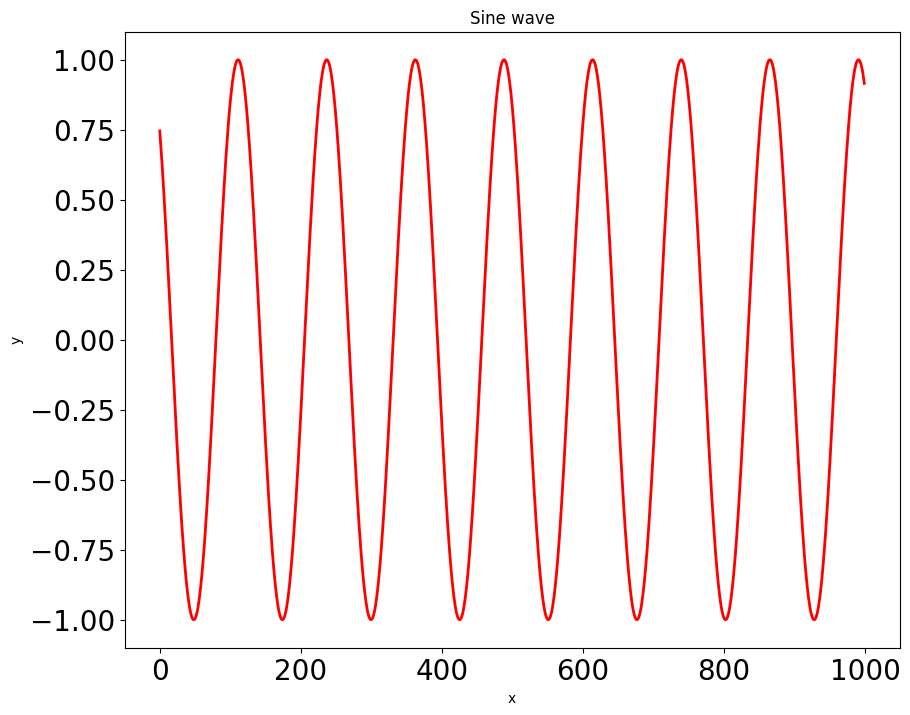

In [17]:
plt.figure(figsize = (10,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.plot(np.arange(x.shape[1]), y[0,:], 'r', linewidth = 2.0)

In [18]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden = 51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm1 lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future = 0):
        # batch_size, 100
        outputs = []
        n_samples = x.size(0)

        h_t = torch.zeros(n_samples, self.n_hidden, dtype = torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype = torch.float32)

        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype = torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype = torch.float32)

        for input_t in x.split(1, dim = 1):
            # batch_size, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim = 1)
        return outputs

In [19]:
# y = (100, 1000)
train_input = torch.from_numpy(y[3:, :-1]) # 97, 999
train_target = torch.from_numpy(y[3:, 1:]) # 97, 999
# print(train_input.shape)
test_input = torch.from_numpy(y[:3, :-1]) # 3, 999
test_target = torch.from_numpy(y[:3, 1:]) # 3,999

model = LSTMPredictor()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr = 0.8)

n_steps = 1
for i in range(n_steps):
    print("Step", i)
    
    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out, train_target)
        print("loss", loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    break

    with torch.no_grad():
        future = 1000
        pred = model(test_input, future = future)
        loss = criterion(pred[:, :-future], test_target)
        print("Test loss", loss.item())
        z = pred.detach().numpy()
        plt.figure(figsize = (12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        n = train_input.shape[1] # 999
        def draw(y_i, color):
            plt.plot(np.arange(n), y_i[:n], color, linewidth = 2.0)
            plt.plot(np.arange(n, n + future), y_i[n:], color + ":", linewidth = 2.0)

        draw(z[0], 'r')
        draw(z[1], 'b')
        draw(z[2], 'g')

        plt.savefig("predicted_%d.pdf"%i)
        plt.close()

Step 0
loss 0.5149250626564026
loss 0.507716953754425
loss 0.48449471592903137
loss 0.4634835422039032
loss 0.3603798449039459
loss 0.16217094659805298
loss 0.062477488070726395
loss 0.02953900583088398
loss 0.024531997740268707
loss 0.023316621780395508
loss 0.023083189502358437
loss 0.02053244411945343
loss 0.016243280842900276
loss 0.007627645507454872
loss 0.015232156962156296
loss 0.002692967187613249
loss 0.002274082275107503
loss 0.001515819109044969
loss 0.00129958416800946
loss 0.0012284431140869856
